In [ ]:
import time
import numpy as np
import pandas as pd

# H&M Personalized Fashion Recommendations


**Collaborative filtering** is one of the most common Recommender System approaches. 
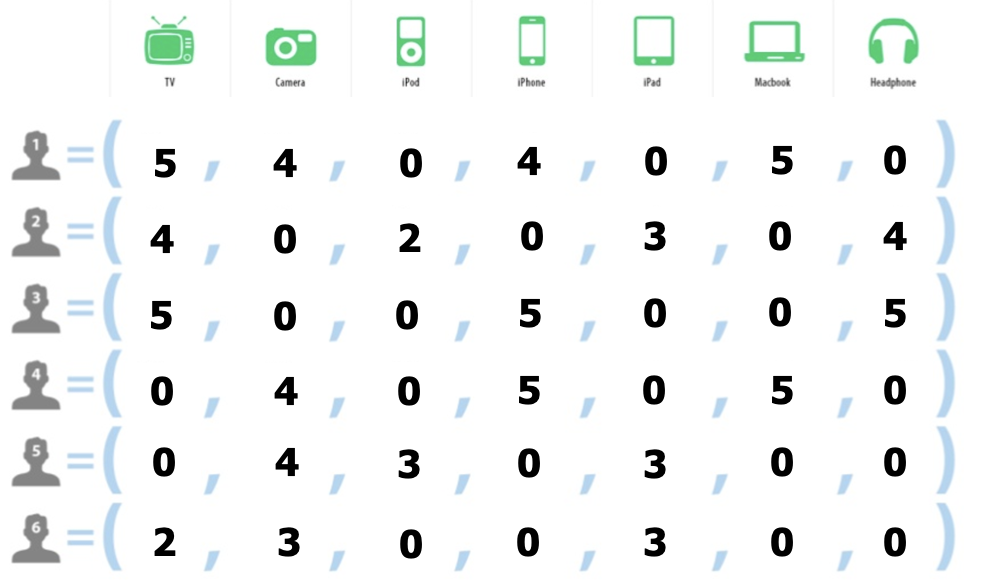


**1. K Nearest Neighbours collaborative filtering:**

    For a given user U, search for K similar users.
    Search for the M most popular items among this K users similar to a given user U.
    Among the M most popular items, find the items that a given user U hasn't purchased yet.
    Recommend those items to a given U.

   **Questions:**

    What does it mean that two users are similar?
    What does it mean that an item is popular among a group of users?

In the simplest case users are represented by the vectors of their purchase.
To calcultate similarity, any proximity measure may be used (cosine, Euclidean distance, hamming distance, etc.).

   **Problem:**

    The vector representing a user will be of size N, where N is the total number of items in the dataset (105 542 for HM). 
    
To find items that are popular, the simplest solution is to take the number of purchases of an item in a group. Purchases of users that are more similar to user U may be assigned a higher weight.

**2. Matrix factorization method based on SVD.**

**Singular Vector Decomposition (SVD)** factorizes the interaction (purchses) matrix (users x items) into **two smaller matrices**, one for item embeddings and one for user embeddings. The multiplication of a user and an item vectiors from those matrices gives (approximately) their **interaction score** (or purchased or not for purchases data). 

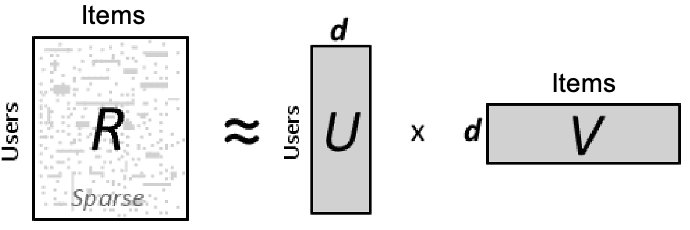

The embeddings for items and users are built in **the same vector space**, so recommendations can be produced **by calculation any proximity meausure** (e.g. cosine distance) between a user and an item.


## SVD based recomendations

### Reduce the dataset

In [5]:
base_path = ''

transactions_path = f'{base_path}transactions_train.csv.zip'
customers_path = f'{base_path}customers.csv.zip'
articles_path = f'{base_path}articles.csv.zip'

transactions = pd.read_csv(transactions_path, dtype={'article_id': str}, parse_dates=['t_dat'])

customers = pd.read_csv(customers_path)
articles = pd.read_csv(articles_path, dtype={'article_id': str})

ALL_USERS = customers['customer_id'].unique().tolist()
ALL_ITEMS = articles['article_id'].unique().tolist()

user_to_customer_map = {customer_id: user_id for user_id, customer_id in enumerate(ALL_USERS)}
item_to_article_map = {article_id: item_id for item_id, article_id in enumerate(ALL_ITEMS)}

del customers, articles

transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1


In [7]:
print(f'There are {len(ALL_USERS)} unique users the dataset.')
print(f'There are {len(ALL_ITEMS)} unique items the dataset.')

There are 1371980 unique users the dataset.
There are 105542 unique items the dataset.


In [8]:
START_DATE = '2020-08-21'

transactions_small = transactions[transactions['t_dat'] > START_DATE].copy()

In [10]:
transactions_small.loc[:,'user_id'] = transactions_small['customer_id'].map(user_to_customer_map)
transactions_small.loc[:,'item_id'] = transactions_small['article_id'].map(item_to_article_map)
transactions_small

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
30597413,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0913688003,0.033881,2,38,103595
30597414,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0913688003,0.033881,2,38,103595
30597415,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0923460001,0.042356,2,38,104483
30597416,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0934380001,0.050831,2,38,105214
30597417,2020-08-22,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0913688001,0.033881,2,38,103593
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1371691,104961
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1371691,100629
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1371721,104053
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1371747,88521


In [11]:
print(f'There are {len(transactions_small.user_id.unique())} unique users with purchases after {START_DATE}.')
print(f'There are {len(transactions_small.item_id.unique())} unique items in the smaller dataset.')

There are 256355 unique users with purchases after 2020-08-21.
There are 29548 unique items in the smaller dataset.


### Form sparse matrixes
https://en.wikipedia.org/wiki/Sparse_matrix

Since a user usually purchases only a small fraction of the catalog items, the interaction matrix is filled mostly by zeros -  it is **sparse**.<br>
As so, sparse matrices representation (e.g. scipy sparse matrices) are widely used in recommender systems to save memory.

Scipy **coo_matrix** (or coordinate list) stores a list of (row, column, value) tuples. 

Scipy **csr_matrix** (compressed sparse row or Yale format) represents a matrix M by three (one-dimensional) arrays, that respectively contain non-zero values, the extents of rows, and column indices. It is similar to COO, but compresses the row indices. 

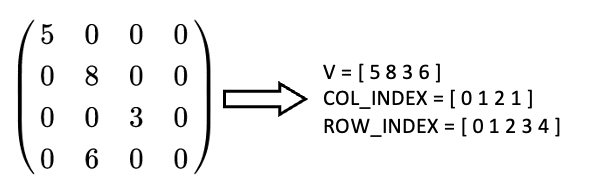

In [ ]:
transactions['t_dat'].min(), transactions['t_dat'].max()

test_days = 30

test_cut = transactions['t_dat'].max() - pd.Timedelta(test_days)

train = transactions[transactions['t_dat'] < test_cut]
test = transactions[transactions['t_dat'] >= test_cut]

In [15]:
from scipy.sparse import coo_matrix

users = transactions_small['user_id'].values
items = transactions_small['item_id'].values

purchases = np.ones(transactions_small.shape[0])

csr_train = coo_matrix((purchases, (users, items))).tocsr()
csr_train

<1371978x105540 sparse matrix of type '<class 'numpy.float64'>'
	with 1051730 stored elements in Compressed Sparse Row format>

In [16]:
print(csr_train[0])

  (0, 16023)	1.0


### Apply Alternating Least Squares from Implicit lib
https://implicit.readthedocs.io/en/latest/index.html

**Implicit** lib uses **Alternating Least Squares** method to factorize interaction matrix.

In [17]:
%%time
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=10, iterations=2,
                                regularization=0.01, 
                                random_state=42)
model.fit(csr_train)

/Users/olko/miniconda3/envs/py39/lib/python3.9/site-packages/implicit/utils.py:28: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 5.13 s, sys: 820 ms, total: 5.95 s
Wall time: 1.93 s


### Calculate mean average presicion at k

In [18]:
from implicit.evaluation import mean_average_precision_at_k

map_12 = mean_average_precision_at_k(model, csr_train, csr_train, K=12, num_threads=4)
map_12

  0%|          | 0/256355 [00:00<?, ?it/s]

0.0

### Get recommendations

In [19]:
user_id = 38
N = 12

recommendations = model.recommend(user_id, csr_train[user_id], N=N, filter_already_liked_items=False)
dict(zip(recommendations[0], recommendations[1]))

{53892: 0.113799915,
 71101: 0.08689333,
 103108: 0.05665836,
 97557: 0.05437774,
 18586: 0.051227115,
 99655: 0.051083792,
 57609: 0.050587047,
 71107: 0.0482874,
 53894: 0.04790492,
 75438: 0.04714005,
 87467: 0.04639939,
 100938: 0.045316156}

In [20]:
item_id = 103595

related_items = model.similar_items(item_id, N=5)
dict(zip(related_items[0], related_items[1]))

{103595: 1.0000001,
 98285: 0.9969111,
 98702: 0.9942513,
 71242: 0.99301183,
 97000: 0.99270767}